In [1]:
import math
import time
import pickle
import pandas as pd
import numpy as np

In [2]:
import torch
import sklearn

In [3]:
from pyqpanda import *

In [4]:
%matplotlib inline

# 1. Prepare Dadaset

In [5]:
# https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [6]:
train_path = './../data/DailyDelhiClimateTrain.csv'
test_path = './../data/DailyDelhiClimateTest.csv'

In [7]:
cols = [1,2,3,4]

train = pd.read_csv(train_path, usecols=cols, engine="python")
test = pd.read_csv(test_path, usecols=cols, engine="python")

In [8]:
print(f'len(train)={len(train)}')
print(f'len(test)={len(test)}')

len(train)=1462
len(test)=114


## 1.1 Outlier Detection

In [9]:
unnormal_num = 0
for i in range(len(train)):
    mp = train.iloc[i][3]
    if mp > 1200 or mp < 950:
        unnormal_num += 1
        train.iloc[i][3] = train.iloc[i + 1][3]
print(f'remove outliers num: {unnormal_num}')

remove outliers num: 9


In [10]:
test.iloc[0][3] = test.iloc[1][3]

## 1.2 Transfer data to LSTM representation

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
def data_process(data, window_size, predict_size):
    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    data_in = []
    data_out = []
    
    for i in range(data.shape[0] - window_size - predict_size):
        data_in.append(data[i:i + window_size].reshape(1, window_size)[0])
        data_out.append(data[i + window_size:i + window_size + predict_size].reshape(1, predict_size)[0])
        
    data_in = np.array(data_in).reshape(-1, window_size)
    data_out = np.array(data_out).reshape(-1, predict_size)
    
    data_process = {'datain': data_in, 'dataout': data_out}
    
    return data_process, scaler

## 1.3 prepare train/test dataset

In [13]:
features_size = 4
window_size = features_size * 3 # features num * time steps
predict_size = features_size # features

In [14]:
train_processed, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
import torch.utils.data as Data

train_data = Data.TensorDataset(X_train, y_train)
test_data = Data.TensorDataset(X_test, y_test)

# 2. Quantum Enhanced LSTM

## 2.1 initiate quantum environment

In [17]:
class InitQMachine:
    def __init__(self, qubitsCount, cbitsCount = 0, machineType = QMachineType.CPU):
        self.machine = init_quantum_machine(machineType)
        
        self.qubits = self.machine.qAlloc_many(qubitsCount)
        self.cbits = self.machine.cAlloc_many(cbitsCount)
        
        print(f'Init Quantum Machine with qubits:[{qubitsCount}] / cbits:[{cbitsCount}] Successfully')
    
    def __del__(self):
        destroy_quantum_machine(self.machine)

In [18]:
# maximum qubits size
ctx = InitQMachine(4)

Init Quantum Machine with qubits:[4] / cbits:[0] Successfully


## 2.2 Quantum Layer

### 2.2.1 Quantum layer base

In [19]:
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter

In [20]:
class QuantumLayerBase(nn.Module):
    def __init__(self, input_size, output_size, *, n_qubits, n_layers = 1, ctx = None):
        super(QuantumLayerBase, self).__init__()
        
        self.data = None # need to input during forward
    
        self.input_size = input_size
        self.output_size = output_size # hidden size, not n_qubits
        
        # quantum infos
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.ctx = ctx
        self.qubits = ctx.qubits
        self.machine = ctx.machine
        
        # convert quantum input/output to match classical computation
        self.qin = nn.Linear(self.input_size, self.n_qubits)
        self.qout = nn.Linear(self.n_qubits, self.output_size)
        
    @property
    def circuit(self):
        raise NotImplementedError('Should init circuit')

In [21]:
def measure(self):
    HamiZ = [ PauliOperator({f'Z{i}': 1}) for i in range(len(self.qubits)) ]
    res = [ eval(qop(self.circuit, Hami, self.machine, self.qubits))[0,0] for Hami in HamiZ ]
    
    return Parameter(Tensor(res[:self.n_qubits]))

QuantumLayerBase.measure = measure

In [22]:
def forward(self, inputs):
    y_t = self.qin(Parameter(inputs))
    self.data = y_t[0]
    
    return self.qout(self.measure())

QuantumLayerBase.forward = forward

### 2.2.2 Quantum layer design

In [23]:
class QuantumLayer(QuantumLayerBase):
    def __init__(self, input_size, output_size, *, n_qubits, degree = 1, n_layers = 1, ctx = None):
        super(QuantumLayer, self).__init__(input_size, output_size, 
                                         n_qubits = n_qubits, n_layers = n_layers, ctx = ctx)
        
        self.degree = degree
        self.angles = Parameter(torch.rand(n_layers, degree, self.n_qubits))
        
    @property
    def qparameters_size(self):
        return self.angles.flatten().size()[0]
        
    @property
    def circuit(self):
        if self.data == None:
            raise ValueError('Need to feed a input data!')
        
        n = self.n_qubits
        q = self.qubits
        x = self.data
        p = self.angles
        degree = self.degree
        
        # quantum gates - must use small case!
        h = VariationalQuantumGate_H
        ry = VariationalQuantumGate_RY
        cx = VariationalQuantumGate_CNOT
        u3 = VariationalQuantumGate_U3
        
        # init variational quantum circuit
        vqc = VariationalQuantumCircuit()

        # encoding layer
        [ vqc.insert( h(q[i]) ) for i in range(n) ]
        [ vqc.insert( ry(q[i], var(x[i] * torch.pi / 2)) ) for i in range(n) ]
        
        # variational layer
        for layer in range(self.n_layers):
            for i in range(n - 1):
                vqc.insert(cx(q[i], q[i + 1]))
            vqc.insert(cx(q[n - 1], q[0]))
        
        for layer in range(self.n_layers):
            for i in range(n - 1):
                vqc.insert(cx(q[i], q[i + 1]))
            vqc.insert(cx(q[n - 1], q[0]))
        
        [ vqc.insert( u3(q[i], *[ var(p[layer][d][i]) for d in range(degree) ]) ) 
                 for i in range(n) ]
        
        return vqc

### 2.2.3 Plot Quantum Layer

In [24]:
data = Tensor([[0.1, 0.2, 0.3, 0.4]])
layer = QuantumLayer(4, 4, n_qubits=4, n_layers=1, degree=3, ctx=ctx)
layer.data = data[0]
vqc = layer.circuit
prog = create_empty_qprog()
prog.insert(vqc.feed())

In [25]:
draw_qprog(prog, 'pic', filename=f'pic/layer1')

'null'

## 2.3 Quantum-LSTM

In [26]:
class QLSTMBase(nn.Module):
    def __init__(self, input_size, hidden_size, *, ctx):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ctx = ctx
        
    @property
    def qparameters_size(self):
        num = 0
        for attr in dir(self):
            if attr.endswith('_circuit'):
                num += getattr(self, attr).qparameters_size
        return num

In [27]:
def forward(self, inputs, init_states = None):
    sequence_size, batch_size, _ = inputs.size()
    hidden_sequence = []
    
    if init_states == None:
        h_t, c_t = (
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
        )
    else:
        h_t, c_t = init_states
    
    return hidden_sequence, (h_t, c_t)

QLSTMBase.forward = forward

## - classical quatum enhanced LSTM

In [28]:
class QLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx):
        super().__init__(input_size, hidden_size, ctx = ctx)
    
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 4, degree = 3, ctx = ctx) # 15
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 4, degree = 3, ctx = ctx) # 15
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, degree = 3, ctx = ctx) # 15
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 4, degree = 3, ctx = ctx) # 15
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        # reshape hidden_seq p/ retornar
        #
        # [tensor([[[0.0444, ...]]] => tensor([[[0.0444, ...]]]
        # 
        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

## 2.4 Stacked QLSTM

In [29]:
from collections import OrderedDict

class StackedQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, *, num_layers = 1, ctx = None, mode = 'classical'):
        super().__init__()
        
        self.qlstms = nn.Sequential(OrderedDict([
            (f'QLSTM {i + 1}', QLSTM(input_size if i == 0 else hidden_size , hidden_size, ctx = ctx)) 
                for i in range(num_layers)
        ]))

    def forward(self, inputs, parameters = None):
        outputs = None
        
        for i, qlstm in enumerate(self.qlstms):
            if i != 0:
                inputs = outputs
            
            outputs, parameters = qlstm(inputs, parameters)
        
        return outputs, parameters

# 3. Quantum Model and Train

In [30]:
class QModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1, ctx = None, mode = 'classical'):
        super(QModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.qlstm = StackedQLSTM(input_size, hidden_size, 
                                  num_layers = num_layers, ctx = ctx, mode = mode)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(1, x.size(1), self.hidden_size)
        c0 = torch.zeros(1, x.size(1), self.hidden_size)
        
        out, _ = self.qlstm(x, (h0, c0))
        out = self.predict(out[0])
        
        return out

## 3.1 train QModel

In [31]:
from torch.utils.data import RandomSampler

def train_model(model, datas, batch_size, *, loss_func, optimizer, epoch = 50):
    losses = []
    sampler = RandomSampler(datas, num_samples = batch_size)
    
    for step in range(epoch):
        train_loss = 0.0
        
        for index in sampler:
            batch_x, batch_y = datas[index][0], datas[index][1]
            b_x = batch_x.unsqueeze(0)
            b_y = batch_y.unsqueeze(0)
            
            output = model(b_x)

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f'Epoch {step + 1}/{epoch}: Loss: {train_loss / batch_size}')
        losses.append(train_loss / batch_size)
    
    return losses

## 3.2 Evaluate Model

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def MAE_naive(actuals, predicteds):
    n = len(actuals)
    err = 0.0
    
    for i in range(1, n):
        err += np.abs(actuals[i] - actuals[i - 1])
    return err / (n - 1)

def calculate_accuarcy(model, X_test, y_test, scaler=test_scaler):
    n = len(X_test)
    
    actuals = []
    predicteds = []
    
    for i in range(0, n, predict_size):
        actual = scaler.inverse_transform(y_test[i:i+1].data)
        actuals.append(np.array(actual[0]))
        predicted = scaler.inverse_transform(model(X_test[i:i+1]).data)
        predicteds.append(np.array(predicted[0]))
    
    actuals = np.array(actuals)
    predicteds = np.array(predicteds)
    
    mae = mean_absolute_error(actuals, predicteds)
    mase = mae / MAE_naive(actuals.flatten(), predicteds.flatten())
    mape = mean_absolute_percentage_error(actuals, predicteds)
    mse = mean_squared_error(actuals, predicteds)
    rmse = mse ** 0.5
    
    return np.array([(1 - mase) * 100, rmse, mse, mae, mape])

## 3.3 Train Model

In [33]:
features_size = 4
window_size = features_size * 3 # 
predict_size = features_size # features

input_size = window_size
num_output = predict_size

hidden_size = 32
num_layers = 2

In [38]:
accuarcies = []
times = []

for i in range(1):
    print(f'training epoch: {i + 1}')
    qmodel = QModel(input_size, hidden_size, num_output, 
                num_layers = num_layers, ctx = ctx, mode='classical')
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.001)
    loss_func = nn.MSELoss()
    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 200)
    end = time.time()

    print(f'time costs: {end - start}')
    times.append(end - start)
    
    acc = calculate_accuarcy(qmodel, X_test, y_test)[0]
    accuarcies.append(acc)
    
    with open(f'loss/layer1/loss_layer1_{i + 1}.pkl', 'wb') as pkl_file:
        pickle.dump(losses, pkl_file)
    torch.save(qmodel.state_dict(), f"model/layer1/model_layer1_{i+1}.pt")
    
    print('-' * 20)

training epoch: 1
Epoch 1/200: Loss: 1.0465084075927735
Epoch 2/200: Loss: 1.0176357984542848
Epoch 3/200: Loss: 1.019245058298111
Epoch 4/200: Loss: 1.0169513016939162
Epoch 5/200: Loss: 1.0056973963975906
Epoch 6/200: Loss: 0.986315381526947
Epoch 7/200: Loss: 0.9866503477096558
Epoch 8/200: Loss: 0.9953180551528931
Epoch 9/200: Loss: 0.9692169278860092
Epoch 10/200: Loss: 0.9781980365514755
Epoch 11/200: Loss: 0.9879008501768112
Epoch 12/200: Loss: 0.9658823788166047
Epoch 13/200: Loss: 0.9631255477666855
Epoch 14/200: Loss: 0.947779169678688
Epoch 15/200: Loss: 0.9458050847053527
Epoch 16/200: Loss: 0.939058730006218
Epoch 17/200: Loss: 0.9364449679851532
Epoch 18/200: Loss: 0.91270911693573
Epoch 19/200: Loss: 0.8850193530321121
Epoch 20/200: Loss: 0.9036007285118103
Epoch 21/200: Loss: 0.9043746948242187
Epoch 22/200: Loss: 0.87623330950737
Epoch 23/200: Loss: 0.8443528413772583
Epoch 24/200: Loss: 0.841423949599266
Epoch 25/200: Loss: 0.8768796384334564
Epoch 26/200: Loss: 0.784

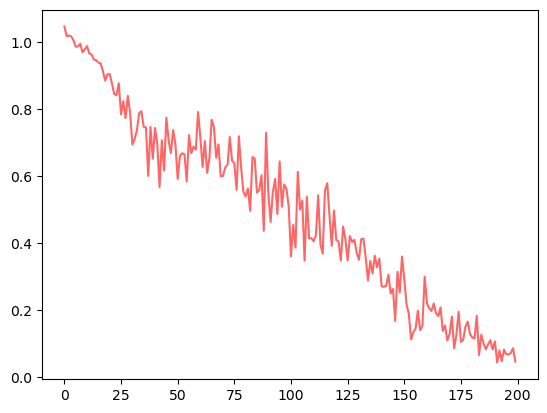

In [39]:
import matplotlib.pyplot as plt

plt.plot(losses, color="#FF6666")

In [40]:
print(f'quantum paramers: {QLSTM(1, 1, ctx = ctx).qparameters_size}')

quantum paramers: 48


In [41]:
accuarcies

[85.13998863740751]

In [40]:
# 49.09517186730443
# 
# [83.28042200996501,
#  46.79652813010892,
#  88.87307263991944,
#  54.86488053929101,
#  38.771207741033585,
#  77.23666113945514,
#  40.24725193003839,
#  52.751618288438685,
#  46.144399595830585,
#  85.98485584865908]
np.mean(accuarcies)

61.495089786273994

In [39]:
# 201.04187800884247
np.mean(times)

351.94433295726776